# A demo of Hilbert-Huang transform

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from hht import hilbert_huang, hilbert_spectrum, plot_IMFs
from scipy.signal import chirp
import IPython

Generate a mixture of two Gaussian-modulated quadratic chirps. Specify a sample rate of 1000Hz and a signal duration of 2.0s. 

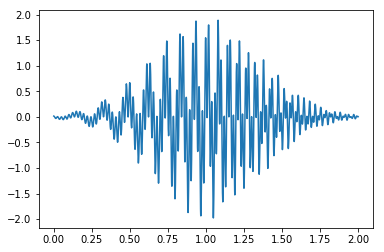

In [2]:
fs = 1000
duration = 2.0
delta_t = 1/fs
t = torch.arange(fs*duration) * delta_t
x = torch.from_numpy(chirp(t, 5, 0.8, 10, method = "quadratic", phi=100)) * torch.exp(-4*(t-1)**2) + \
    torch.from_numpy(chirp(t, 40, 1.2, 50, method = "linear")) * torch.exp(-4*(t-1)**2)
plt.plot(t, x) 

Now let's perform empirical mode decomposition (EMD). 

In [3]:
imfs, imfs_env, imfs_freq = hilbert_huang(x, delta_t, num_extrema=3)

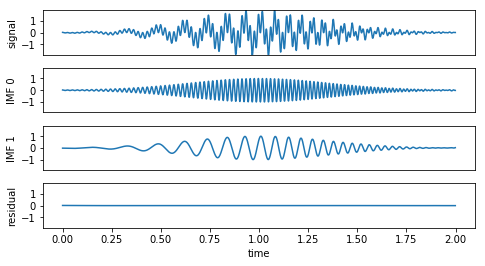

In [4]:
plot_IMFs(x, imfs, delta_t)

From the above illustration we can see than the two modulated chirps are successfully separated and represented by `IMF 0` and `IMF 1`. Now let's further visualize the time-frequency spectrum. We discard the spectrum in the first an d last 0.25s since the endpoint effect severely corrupt the low-frequency components in the spectrum.

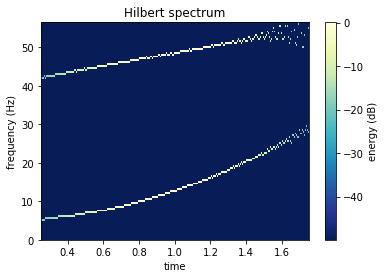

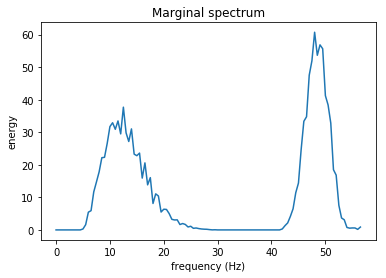

In [5]:
spectrum, t, f = hilbert_spectrum(imfs_env, imfs_freq, delta_t, time_range = (0.25, 1.75))

In the illustration, the variation of frequencies over time can be clearly seen - one increases linearly from 40Hz, reaching 50Hz at 1.2s, and the other increases quadratically from 5Hz, reaching 10Hz at 0.8s. From the color map one can observe that both of their amplitudes are modulated. All of these match our parameters for the chirps. The marginal spectrum also show two peaks of the frequency distribution.
Now let's perform windowed-based Fourier transform (short-time Fourier transform) for comparison.

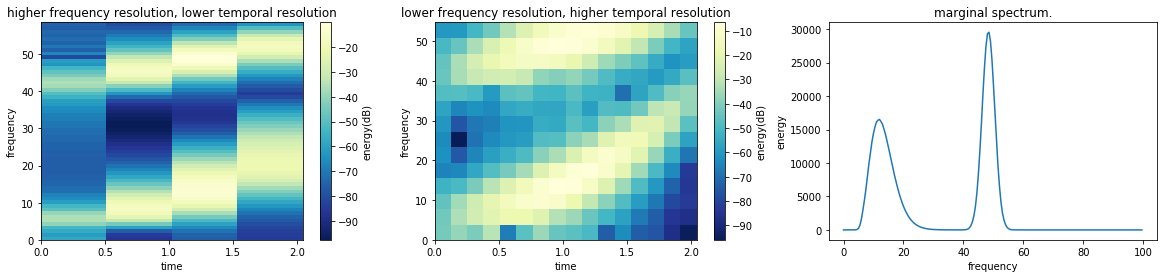

In [6]:
from scipy.signal import stft
from scipy import fft
plt.figure(figsize=(20, 4))

f, t, Zxx = stft(x, fs, nperseg=1024)
f_lim = int(60/f[1])
ax = plt.subplot(1, 3, 1)
plt.colorbar(ax.pcolormesh(t, f[:f_lim], 20 * np.log10(np.abs(Zxx))[:f_lim, :], cmap = plt.cm.YlGnBu_r), label="energy(dB)")
ax.set_xlabel("time")
ax.set_ylabel("frequency")
ax.set_title("higher frequency resolution, lower temporal resolution")

f, t, Zxx = stft(x, fs, nperseg=256)
f_lim = int(60/f[1])
ax = plt.subplot(1, 3, 2)
plt.colorbar(ax.pcolormesh(t, f[:f_lim], 20 * np.log10(np.abs(Zxx))[:f_lim, :], cmap = plt.cm.YlGnBu_r), label="energy(dB)")
ax.set_xlabel("time")
ax.set_ylabel("frequency")
ax.set_title("lower frequency resolution, higher temporal resolution")

X = fft(x)
ax = plt.subplot(1, 3, 3)
f_lim = int(100/fs*x.shape[0])
ax.plot(np.arange(f_lim)/x.shape[0]*fs, (np.abs(X)**2)[:f_lim])
ax.set_xlabel("frequency")
ax.set_ylabel("energy")
ax.set_title("marginal spectrum.")
plt.show()

The FFT spectrum is similar to the Hilbert one. However, in the STFT spectrum, due to the uncertainty principle, the frequency and temporal resolutions can not be fine enough at the same time. The Fourier analysis treats the non-linear modulation linearly, resulting in a blurred spectrum (consisting of a lot of energy leakage and unnecessary harmonics).